## Setup Environment

In [0]:
!unzip winter2020-mais-202.zip

Archive:  winter2020-mais-202.zip
  inflating: label_int_to_str_mapping.csv  
  inflating: sample_submission.csv   
  inflating: test_images.npy         
  inflating: train_images.npy        
  inflating: train_labels.csv        


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%tensorflow_version 2.x

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten, AveragePooling2D, Attention, Input, BatchNormalization, Activation

from scipy import ndimage
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from random import randint

TensorFlow is already loaded. Please restart the runtime to change versions.


## Load Data

In [0]:
reg_labels = np.array(pd.read_csv("train_labels.csv")['label'])
reg_images = np.reshape(np.load("train_images.npy"), (50000,28,28,1))

Save Some Regular Images for Testing

In [0]:
reg_images, final_test_images, reg_labels, final_test_labels = train_test_split(reg_images, reg_labels, test_size=0.01, random_state=1)

Rotate Regular Data

In [0]:
rotations = 10
new_imgs = np.array([ndimage.rotate(img, 360 / rotations * r + randint(0, 360 / rotations), reshape=False, mode="constant", cval=75) for img in reg_images for r in range(rotations)])
new_labels = np.array([label for label in reg_labels for r in range(rotations)])

Add New Data

In [0]:
train_images = reg_images
# train_images = np.concatenate((reg_images, new_imgs))

train_labels = reg_labels
# train_labels = np.concatenate((reg_labels, new_labels))

Save Data For AutoML

Verify Data

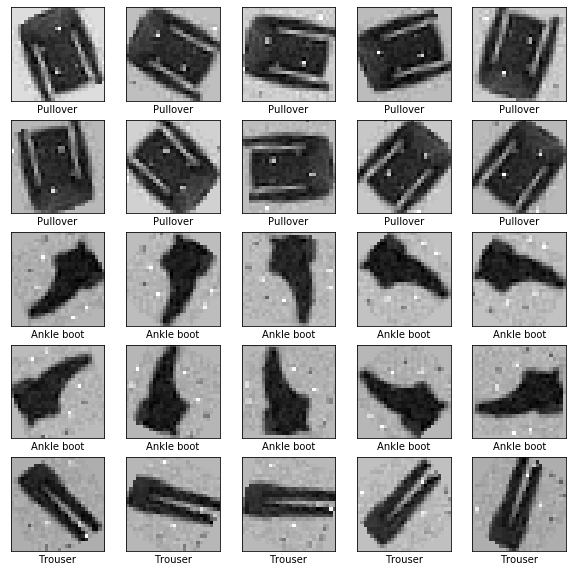

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(new_imgs[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.xlabel(class_names[new_labels[i]])
plt.show()

One-Hot Encode Labels

In [0]:
onehot_encoder = OneHotEncoder(sparse=False)
train_labels = onehot_encoder.fit_transform(train_labels.reshape((-1, 1)))
final_test_labels = onehot_encoder.fit_transform(final_test_labels.reshape((-1, 1)))

Split Data

In [0]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.05, random_state=1)

Normalize Images

In [0]:
train_images = (train_images / 255.0)
val_images = (val_images / 255.0)
reg_images = (reg_images / 255.0)
final_test_images = (final_test_images / 255.0)

## Model

Define Model

In [0]:
model = Sequential()
# Add convolution 2D
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))


Compile Model

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train

In [0]:
model.fit(train_images, train_labels, epochs=50,
          validation_data=(val_images, val_labels))

Train on 47025 samples, validate on 2475 samples
Epoch 1/50
47025/47025 [==============================] - 8s 168us/sample - loss: 1.8563 - acc: 0.6051 - val_loss: 1.7855 - val_acc: 0.6739
Epoch 2/50
47025/47025 [==============================] - 7s 147us/sample - loss: 1.7834 - acc: 0.6771 - val_loss: 1.7729 - val_acc: 0.6877
Epoch 3/50
32096/47025 [===================>..........] - ETA: 2s - loss: 1.7692 - acc: 0.6914

KeyboardInterrupt: ignored

## Evaluate

In [0]:
test_loss, test_acc = model.evaluate(final_test_images,  final_test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

500/500 - 0s - loss: 1.6027 - acc: 0.8540

Test accuracy: 0.854


## Submit

Get Predictions

In [0]:
x_test = np.load('test_images.npy').squeeze()
x_test = x_test.reshape((-1, 28, 28, 1))
x_test = x_test / 255.0
y_test = model.predict_classes(x_test)

AttributeError: ignored

Verify Predictions

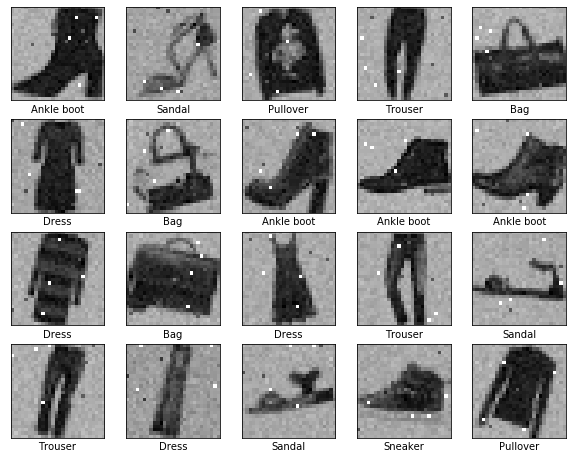

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.xlabel(class_names[y_test[i]])
plt.show()

Generate CSV

In [0]:
df_test = pd.read_csv('sample_submission.csv')
df_test['label'] = y_test
df_test.to_csv('submission.csv', index=False)